In [ ]:
"""
Reason for Developing this
1) I got bored after my Fall break
2) I wanted to beat my friend quickly
3) I wanted to explore Computer Vision (Open CV) and learn a graph algorithm along the way :)
"""

In [161]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

In [162]:
# Reading Input image
img=cv2.imread('./images/block5.jpeg')

(-0.5, 539.5, 730.5, -0.5)

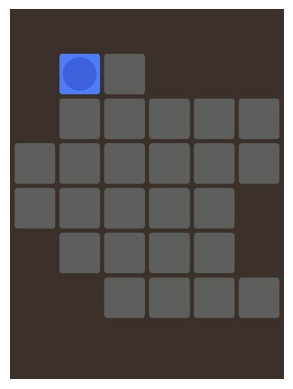

In [163]:
# Displaying the image
plt.imshow(img)
plt.axis('off')

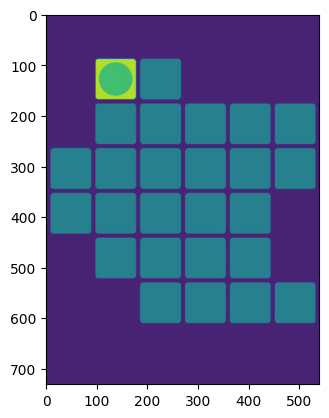

In [164]:
# Converting Image to gray scale
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray)

In [119]:
"""
Creating an inverted binary image where all the pixel values greater than 50 are coverted to 0 (Black) and the rest to 255 (White)
"""
start,binary_converted_array=cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)

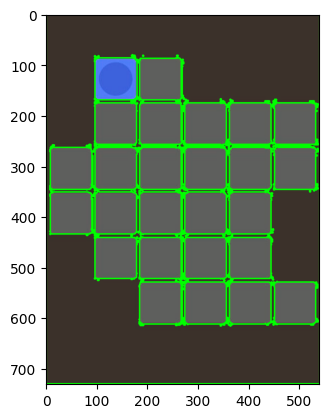

In [165]:
# Contouring - To separate the background from the foreground
contours, hierarchy = cv2.findContours(binary_converted_array, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for contour in contours:
    cv2.drawContours(img, [contour], -1, (0, 255, 0), 2)
plt.imshow(img)

In [166]:
"""
Trying to approximate the average box dimensions within the grid.
This will be used to later figure out whether the box is part of the grid or if its not.
"""
i=0
top_left_grid=[]
bottom_right_grid=[]

mean_width_of_box=0
mean_height_of_box=0
for contour in contours[1:]:
    x, y, w, h = cv2.boundingRect(contour)
    if(w>50 and h>50):
        mean_width_of_box+=w
        mean_height_of_box+=h
        i+=1
        top_left_grid.append([x,y])
        bottom_right_grid.append([x+w,y+h])
mean_width_of_box=mean_width_of_box/i
mean_height_of_box=mean_height_of_box/i

# approx_area_of_box=round(mean_width_of_box,0)*round(mean_height_of_box,0)
# approx_area_of_box
# mean_width_of_box
# mean_height_of_box

In [167]:
"""
Finding the top left x and y coordinates and bottom right x and y coordinates - Used to Crop the Image
"""
top_left_min_x=float('inf')
top_left_min_y=float('inf')


bottom_right_max_x=0
bottom_right_max_y=0
for i,j in top_left_grid:
    top_left_min_x=min(top_left_min_x,i)
    top_left_min_y=min(top_left_min_y,j)  

for i,j in bottom_right_grid:
    bottom_right_max_x=max(bottom_right_max_x,i)
    bottom_right_max_y=max(bottom_right_max_y,j)
    
breadth = abs((top_left_min_x - bottom_right_max_x))
length = abs((top_left_min_y - bottom_right_max_y))
length,breadth

(528, 527)

In [128]:
# approx number of boxes in grid
# area_of_grid/approx_area_of_box

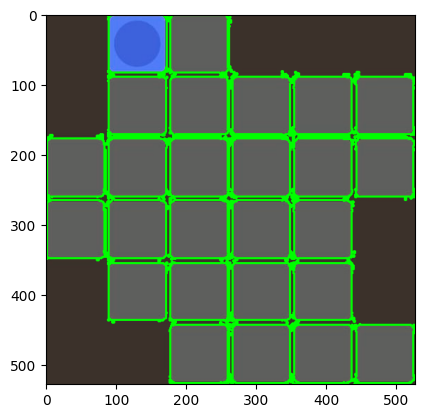

In [168]:
cropped_img=img[top_left_min_y:bottom_right_max_y, top_left_min_x:bottom_right_max_x]
plt.imshow(cropped_img)

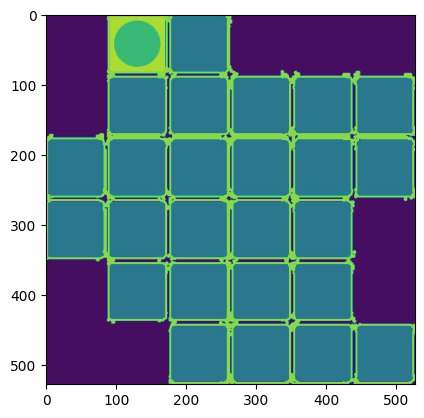

In [169]:
# Converting the image to a gray scale cause I dont want to work with 3D matrices
gray_cropped=cv2.cvtColor(cropped_img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray_cropped)

In [170]:
# Getting Rough size of the block in each grid because I will be iterating block/chunk wise to identify if it is a path or not.
chunk_size=int((mean_width_of_box+mean_height_of_box)//2)
chunk_size

84

In [171]:
# Fair Approximation - Grid dimensions will be ratio of length/breadth to mean height/width of block 
length_grid=round(length/mean_height_of_box)
width_grid=round(breadth/mean_width_of_box)
max_blocks_grid=length_grid*width_grid
max_blocks_grid

36

In [172]:
dimensions_of_grid=length_grid,width_grid
dimensions_of_grid

(6, 6)

In [173]:
"""
If you notice, there are small gaps between each grid. 
I am calculating that pixel value so that I can add that offset while iterating through the Grid
chunk_size*length_grid will be lesser than length of the grid. They would be equal to each other if there were no gaps.
I am dividing by (width of the grid - 1) to get the offet/clearance size of a singular gap
"""
clearance_size=round((length - chunk_size*length_grid)/(width_grid-1))
clearance_size

5

In [174]:
matrix=[]
max_pixel=0
row=0
for y in range(0, length, chunk_size+clearance_size):
    curr_row = []
    column=0
    for x in range(0, breadth, chunk_size+clearance_size):
        # These are the bottom right corner coordinates of the block
        y_end = min(y + chunk_size+clearance_size, length)
        x_end = min(x + chunk_size+clearance_size, breadth)
        
        # Extract the block
        chunk = gray_cropped[y:y_end, x:x_end]
        
        # Calculate mean color value 
        mean_per_channel = np.mean(chunk, axis=(0, 1))
        
        # The game gives you a starting point - Lucky for me it is the block whose pixel intensity is the highest
        if(max_pixel<mean_per_channel):
            max_pixel=mean_per_channel
            starting_coordinate=[row,column]
        # Handling an edge case
        if len(curr_row) == width_grid:
            break
        # From trial and error I observed that all blocks whose mean color value is > 70 belongs to a traversable path
        if np.mean(mean_per_channel) > 70:
            curr_row.append(1)
        else:
            curr_row.append(0)
        column+=1
    row+=1   
    matrix.append(curr_row)
    # Handling an edge case
    if len(matrix) == length_grid:
        break

In [175]:
# Creating a reference input matrix - This helps me give an actual number to each block in the grid
reference_input=[]
current_row=[]
node=0
for i in range(length_grid):
    current_row=[]
    for j in range(width_grid):
        current_row.append(node)
        node+=1
    reference_input.append(current_row)
reference_input

[[0, 1, 2, 3, 4, 5],
 [6, 7, 8, 9, 10, 11],
 [12, 13, 14, 15, 16, 17],
 [18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29],
 [30, 31, 32, 33, 34, 35]]

In [146]:
# This is how my matrix actually looks like right now
matrix

[[0, 1, 1, 0, 0, 0],
 [0, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 0],
 [0, 1, 1, 1, 1, 0],
 [0, 0, 1, 1, 1, 1]]

In [176]:
# Node number for starting point - As mentioned earlier, the game gives you a starting point
reference_input[starting_coordinate[0]][starting_coordinate[1]]

1

In [178]:
# Creating an Adjacency Matrix

def is_within_bounds(x, y, nrows, ncols):
    return 0 <= x < nrows and 0 <= y < ncols

nrows = len(matrix)
ncols = len(matrix[0])


adj_matrix = defaultdict(list)

for i in range(nrows):
    for j in range(ncols):
        if matrix[i][j] == 0:
            continue

        if is_within_bounds(i + 1, j, nrows, ncols) and matrix[i + 1][j] == 1:
            adj_matrix[reference_input[i][j]].append(reference_input[i + 1][j])
        
        if is_within_bounds(i - 1, j, nrows, ncols) and matrix[i - 1][j] == 1:
            adj_matrix[reference_input[i][j]].append(reference_input[i - 1][j])
        
        if is_within_bounds(i, j + 1, nrows, ncols) and matrix[i][j + 1] == 1:
            adj_matrix[reference_input[i][j]].append(reference_input[i][j + 1])
        
        if is_within_bounds(i, j - 1, nrows, ncols) and matrix[i][j - 1] == 1:
            adj_matrix[reference_input[i][j]].append(reference_input[i][j - 1])
adj_matrix

defaultdict(list,
            {1: [7, 2],
             2: [8, 1],
             7: [13, 1, 8],
             8: [14, 2, 9, 7],
             9: [15, 10, 8],
             10: [16, 11, 9],
             11: [17, 10],
             12: [18, 13],
             13: [19, 7, 14, 12],
             14: [20, 8, 15, 13],
             15: [21, 9, 16, 14],
             16: [22, 10, 17, 15],
             17: [11, 16],
             18: [12, 19],
             19: [25, 13, 20, 18],
             20: [26, 14, 21, 19],
             21: [27, 15, 22, 20],
             22: [28, 16, 21],
             25: [19, 26],
             26: [32, 20, 27, 25],
             27: [33, 21, 28, 26],
             28: [34, 22, 27],
             32: [26, 33],
             33: [27, 34, 32],
             34: [28, 35, 33],
             35: [34]})

In [149]:
# Hamiltonian path - Graph algoirhtm that finds a path that visits every node exactly once
def hamiltonian_path_exists(graph, start_node):
    def backtrack(node, visited, path):
        # Mark the node as visited and add it to the path
        visited.add(node)
        path.append(node)
        
        # If all nodes are visited, we have found a Hamiltonian Path
        if len(visited) == total_nodes:
            return True
        
        # Explore neighbors
        for neighbor in graph[node]:
            if neighbor not in visited:
                if backtrack(neighbor, visited, path):
                    return True
        
        # Unmark the node as visited and remove it from the path
        visited.remove(node)
        path.pop()
        return False

    # Total number of nodes in the graph
    total_nodes = len(graph)
    visited = set()
    path = []
    
    # Start the backtracking from the start_node
    if backtrack(start_node, visited, path):
        return path
    else:
        return None

start_node = reference_input[starting_coordinate[0]][starting_coordinate[1]]

# Check if a Hamiltonian Path exists and get the path
path = hamiltonian_path_exists(adj_matrix, start_node)
if path:
    print(f"Path exists starting from node {start_node}: {path}")
else:
    print(f"Path exists starting from node {start_node}.")


Hamiltonian Path exists starting from node 1: [1, 2, 8, 7, 13, 12, 18, 19, 25, 26, 32, 33, 27, 21, 20, 14, 15, 9, 10, 11, 17, 16, 22, 28, 34, 35]
